In [1]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Localisation du projet name et table_id sur gcp
project="marbotic"
table_id = "marbotic_dataset.event_properties"

In [3]:
#TODO : Cette fonction doit être dans un fichier .py partagé. Attribut,key_path.json retourn un credential
#intégration des credentials 
from google.oauth2 import service_account

key_path = "/Users/antonin/code/AntoninAnq/gcp/marbotic-7d02fac30bd8.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

In [4]:
query = """
    SELECT um.user_id, um.user_creation_time,sm.session_id,sm.game_events,sm.session_end,sm.session_start
    FROM `marbotic.marbotic_dataset.sessions_metrics` as sm 
    JOIN marbotic_dataset.users_metrics as um ON sm.user_id=um.user_id
"""

In [5]:
#TODO : Cette fonction doit être dans un fichier .py partagé. 
def extract(project, credentials, query):
    '''Giving project name on GCP with credential. Doing a query and getting a dataframe of the result'''
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [6]:
raw_data = extract(project, credentials, query)

In [7]:
raw_data

,user_id,user_creation_time,session_id,game_events,session_end,session_start
0,65616.0,2021-11-20 15:17:18.537000+00:00,1.647421e+12,6.0,2022-03-16 08:58:14.214000+00:00,2022-03-16 08:56:40.722000+00:00
1,65616.0,2021-11-20 15:17:18.537000+00:00,1.647421e+12,5.0,2022-03-16 08:58:45.380000+00:00,2022-03-16 08:58:28.269000+00:00
2,65616.0,2021-11-20 15:17:18.537000+00:00,1.648134e+12,5.0,2022-03-24 15:06:35.838000+00:00,2022-03-24 15:06:21.426000+00:00
3,65616.0,2021-11-20 15:17:18.537000+00:00,1.647421e+12,5.0,2022-03-16 08:57:59.845000+00:00,2022-03-16 08:57:48.381000+00:00
4,66337.0,2021-12-07 18:08:20.505000+00:00,1.646641e+12,6.0,2022-03-07 08:25:39.783000+00:00,2022-03-07 08:24:40.937000+00:00
...,...,...,...,...,...,...
18811,67695.0,2021-12-30 12:49:27.144000+00:00,1.646491e+12,5.0,2022-03-05 14:40:14.517000+00:00,2022-03-05 14:39:48.894000+00:00
18812,73074.0,2022-05-08 16:29:14.356000+00:00,1.652027e+12,0.0,2022-05-08 16:39:55.181000+00:00,2022-05-08 16:32:21.326000+00:00
18813,73074.0,2022-05-08 16:29:14.356000+00:00,1.652029e+12,0.0,2022-05-08 17:01:24.501000+00:00,2022-05-08 16:58:54.378000+00:00
18814,73074.0,2022-05-08 16:29:14.356000+00:00,1.652377e+12,19.0,2022-05-12 18:05:34.559000+00:00,2022-05-12 17:38:47.898000+00:00


In [8]:
#"game_events" added on cohorts.columns

def _generate_cohorts(dataset, metric):
    cohorts = dataset.groupby(['cohort','order_period']).agg({
        'user_id':pd.Series.nunique, "game_events":pd.Series.sum, "session_id":pd.Series.nunique})
  
 
    cohorts.columns = ["user_id", "session_id","game_events"]
    
    cohorts = cohorts[metric].unstack(0)
    
    return cohorts

In [9]:
#client_event_time replace by session_start
def generate_cohort_analysis(df, metric, record_type='all', period_agg='weekly', fig=True, size=10, save_fig=True):
    
    """
    For metric use 'number_of_orders', 'number_of_items_bought'  or 'total_order_value'
    For record_type use 'all' or specific customer_type ['private','company','government']
    no_fig controlls the output of a figure, by default True (i.e. no figure)
    """
    
    dataset = df.copy()
    
    
    if record_type != 'all':
        dataset = df[df.user_type == record_type].copy()
        
    # format dates (i.e. map customers into their cohort and orders into the respective order period)
    if period_agg=='weekly':
        dataset['cohort'] = dataset['user_creation_time'].apply(lambda x: x.strftime('%Y-%W'))
        dataset['order_period'] = dataset['session_start'].apply(lambda x: x.strftime('%Y-%W'))
        dataset=dataset[dataset["cohort"]>="2022-01"]
    elif period_agg=='monthly':
        dataset['cohort'] = dataset['user_creation_time'].apply(lambda x: x.strftime('%Y-%m'))
        dataset['order_period'] = dataset['session_start'].apply(lambda x: x.strftime('%Y-%m'))
        dataset=dataset[dataset["cohort"]>="2022-01"]
    elif period_agg=='daily':
        dataset['cohort'] = dataset['user_creation_time'].apply(lambda x: x.strftime('%Y-%m-%d'))
        dataset['order_period'] = dataset['session_start'].apply(lambda x: x.strftime('%Y-%m-%d'))
        dataset=dataset[dataset["cohort"]>="2022-04-01"]
    else:
        raise NotImplementedError(f'period_agg: {period_agg} is not implemented')
    
    
    
    # generate cohorts
    cohorts = _generate_cohorts(dataset,metric)
    return cohorts

In [10]:
df_cohort = generate_cohort_analysis(raw_data, "game_events", period_agg='weekly', fig=True, size=10, save_fig=False)


In [11]:
df_cohort = df_cohort.fillna(0)
df_cohort = df_cohort.T
df_cohort

order_period,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2022-13,2022-14,2022-15,2022-16,2022-17,2022-18,2022-19,2022-22
cohort,,,,,,,,,,,,,,,,,,,
2022-01,0.0,0.0,0.0,0.0,1.0,0.0,4.0,70.0,67.0,59.0,61.0,54.0,47.0,39.0,47.0,11.0,49.0,24.0,0.0
2022-02,2.0,0.0,0.0,5.0,10.0,0.0,17.0,103.0,62.0,55.0,60.0,40.0,32.0,59.0,56.0,6.0,23.0,6.0,0.0
2022-03,0.0,7.0,5.0,5.0,4.0,2.0,6.0,48.0,79.0,55.0,65.0,43.0,54.0,35.0,34.0,4.0,34.0,23.0,0.0
2022-04,0.0,0.0,0.0,1.0,5.0,3.0,7.0,50.0,106.0,65.0,71.0,60.0,36.0,30.0,37.0,8.0,48.0,5.0,1.0
2022-05,0.0,0.0,0.0,2.0,0.0,3.0,2.0,62.0,37.0,41.0,66.0,62.0,35.0,35.0,38.0,4.0,22.0,17.0,0.0
2022-06,0.0,0.0,0.0,0.0,5.0,2.0,5.0,82.0,88.0,73.0,46.0,29.0,33.0,35.0,41.0,7.0,33.0,13.0,0.0
2022-07,0.0,0.0,0.0,0.0,0.0,2.0,3.0,63.0,64.0,58.0,72.0,50.0,57.0,37.0,32.0,7.0,22.0,13.0,0.0
2022-08,0.0,0.0,0.0,0.0,0.0,0.0,9.0,104.0,67.0,50.0,44.0,38.0,27.0,14.0,16.0,9.0,16.0,18.0,0.0
2022-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347.0,198.0,88.0,51.0,53.0,61.0,75.0,68.0,3.0,75.0,41.0,0.0


In [12]:
mat_list = [f"mat_{i+1}" for i in range(19)]

In [13]:
cohort = pd.DataFrame(columns=mat_list).T

In [14]:
cohort.reset_index(inplace=True)
cohort

,index
0,mat_1
1,mat_2
2,mat_3
3,mat_4
4,mat_5
5,mat_6
6,mat_7
7,mat_8
8,mat_9
9,mat_10


In [15]:
tmp = pd.DataFrame()
for f in range(df_cohort.shape[0]):
    for i,v in enumerate(df_cohort.iloc[f]):
        if v == 0 :
            pass
        else :  
            cohort[df_cohort.iloc[f].name] = df_cohort.iloc[f][i:].reset_index(drop=True)
            break

In [16]:
cohort.set_index('index',inplace=True)
cohort = cohort.fillna(0).T
cohort

index,mat_1,mat_2,mat_3,mat_4,mat_5,mat_6,mat_7,mat_8,mat_9,mat_10,mat_11,mat_12,mat_13,mat_14,mat_15,mat_16,mat_17,mat_18,mat_19
2022-01,1.0,0.0,4.0,70.0,67.0,59.0,61.0,54.0,47.0,39.0,47.0,11.0,49.0,24.0,0.0,0.0,0.0,0.0,0.0
2022-02,2.0,0.0,0.0,5.0,10.0,0.0,17.0,103.0,62.0,55.0,60.0,40.0,32.0,59.0,56.0,6.0,23.0,6.0,0.0
2022-03,7.0,5.0,5.0,4.0,2.0,6.0,48.0,79.0,55.0,65.0,43.0,54.0,35.0,34.0,4.0,34.0,23.0,0.0,0.0
2022-04,1.0,5.0,3.0,7.0,50.0,106.0,65.0,71.0,60.0,36.0,30.0,37.0,8.0,48.0,5.0,1.0,0.0,0.0,0.0
2022-05,2.0,0.0,3.0,2.0,62.0,37.0,41.0,66.0,62.0,35.0,35.0,38.0,4.0,22.0,17.0,0.0,0.0,0.0,0.0
2022-06,5.0,2.0,5.0,82.0,88.0,73.0,46.0,29.0,33.0,35.0,41.0,7.0,33.0,13.0,0.0,0.0,0.0,0.0,0.0
2022-07,2.0,3.0,63.0,64.0,58.0,72.0,50.0,57.0,37.0,32.0,7.0,22.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08,9.0,104.0,67.0,50.0,44.0,38.0,27.0,14.0,16.0,9.0,16.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09,347.0,198.0,88.0,51.0,53.0,61.0,75.0,68.0,3.0,75.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10,1.0,384.0,260.0,212.0,140.0,106.0,66.0,105.0,23.0,77.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
y_list = []
for f in cohort.columns:
    y_list.append(cohort[f].mean())

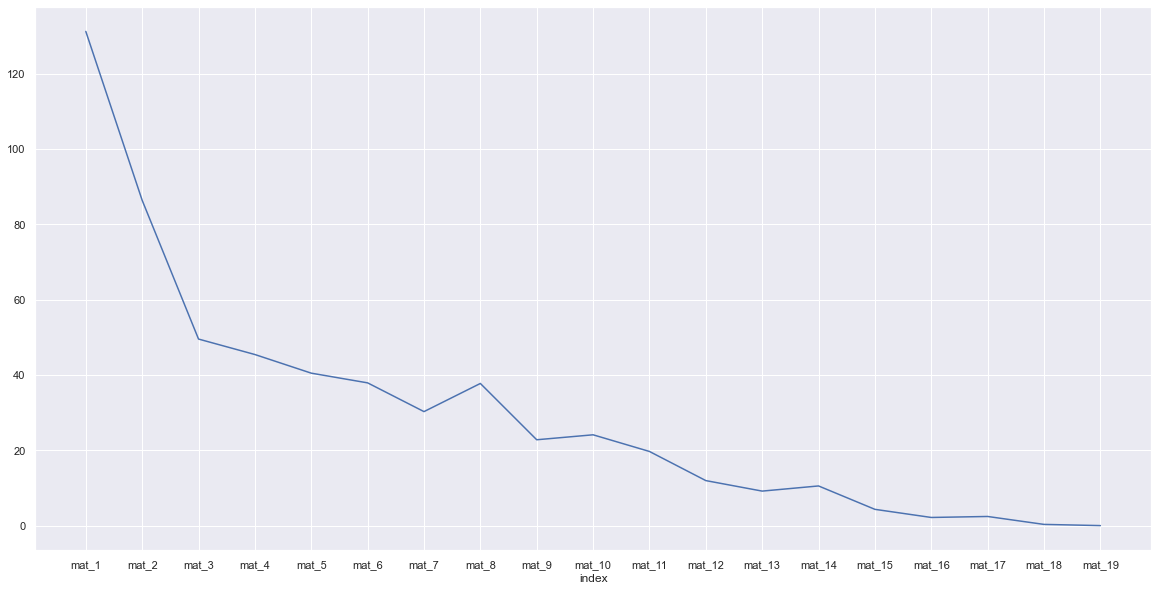

In [20]:
x = cohort.columns
y = y_list

sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(data=cohort,x=x,y=y);

In [21]:
cohort.shape[0]

19

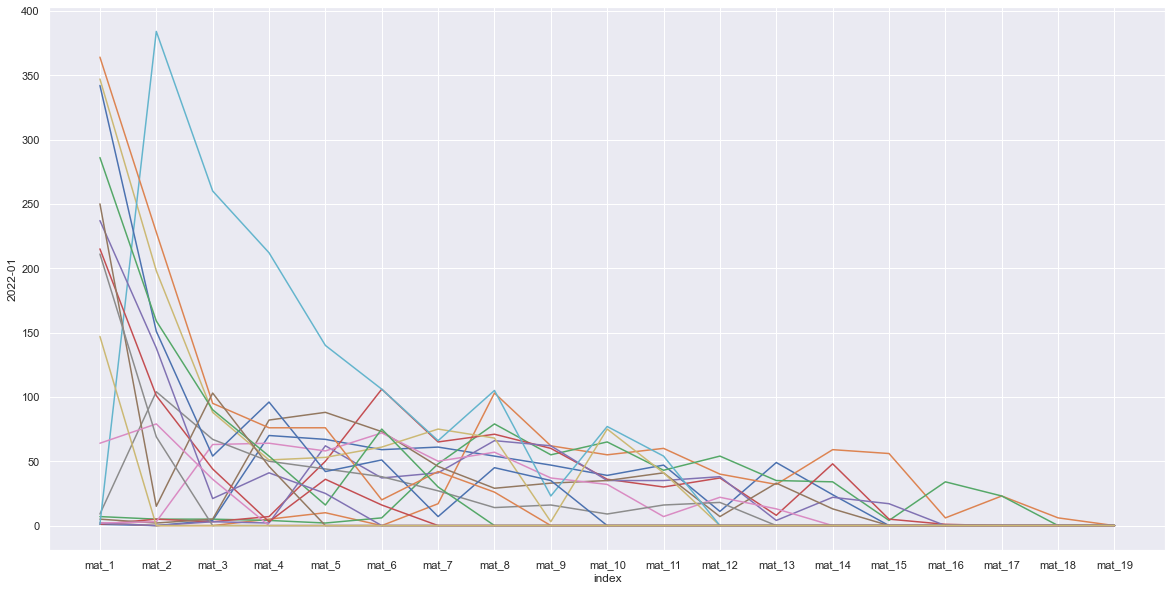

In [23]:
for l in range(cohort.shape[0]):
    sns.lineplot(data=cohort,x=x,y=cohort.iloc[l]);